In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import shap

from matplotlib import pyplot as plt

2023-05-03 17:34:36.846158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
csv_file = 'HeartDiseaseLarge.csv'
df = pd.read_csv(csv_file)
df = df.sample(frac=1).reset_index(drop=True) # shuffle all rows and reset index

df.drop(columns = ['eid'],inplace=True) # Drop the eid
n_patients = len(df.index) # Number of all patients

In [3]:
target = df.pop('HeartDisease') # OUTPUT
features = df
target

0        0
1        1
2        1
3        1
4        0
        ..
24257    0
24258    0
24259    0
24260    0
24261    0
Name: HeartDisease, Length: 24262, dtype: int64

In [4]:
# Constants for training/testing and batching
TEST_SIZE = 0.1 # same as validation size; train size = 1-2*test_size
BATCH_SIZE = 128
MAX_EPOCHS = 50

In [7]:
# split into train/test
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=1)
# split train into train/val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(TEST_SIZE/(1-TEST_SIZE)), random_state=1) # 0.1\0.9 * 0.9 (train size after 1 split) = validation size

In [8]:
# Normalize input layer
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(features)
# Build the model
model = tf.keras.Sequential()
model.add(norm_layer)
model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization()) # trying batch norm after activation (should also try before)
model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))


model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 53)               107       
 n)                                                              
                                                                 
 dense (Dense)               (None, 20)                1080      
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 batch_normalization_1 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                        

In [10]:
history = model.fit(
    x_train, y_train,
    epochs = MAX_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (x_val, y_val),
    verbose = 1)

Epoch 1/50
152/152 [==============================] - 2s 3ms/step - loss: 1.1947 - accuracy: 0.6544 - precision: 0.3510 - recall: 0.3657 - val_loss: 0.9988 - val_accuracy: 0.7487 - val_precision: 0.5938 - val_recall: 0.0308
Epoch 2/50
152/152 [==============================] - 0s 1ms/step - loss: 0.9056 - accuracy: 0.7307 - precision: 0.4684 - recall: 0.1549 - val_loss: 0.8069 - val_accuracy: 0.7478 - val_precision: 0.5909 - val_recall: 0.0211
Epoch 3/50
152/152 [==============================] - 0s 2ms/step - loss: 0.7602 - accuracy: 0.7390 - precision: 0.5180 - recall: 0.1518 - val_loss: 0.7032 - val_accuracy: 0.7478 - val_precision: 0.5625 - val_recall: 0.0292
Epoch 4/50
152/152 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.7412 - precision: 0.5318 - recall: 0.1569 - val_loss: 0.6388 - val_accuracy: 0.7499 - val_precision: 0.5957 - val_recall: 0.0455
Epoch 5/50
152/152 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.7417 - pr

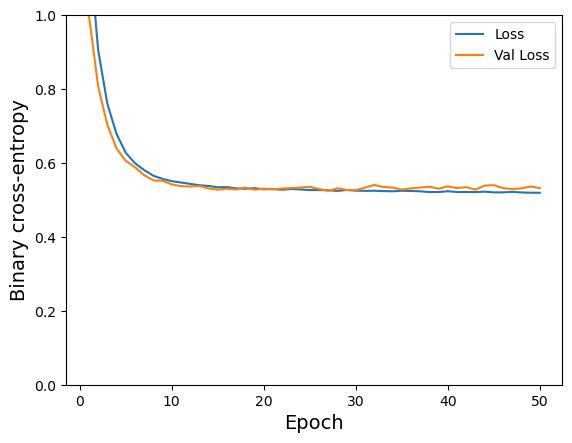

In [11]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();

M&F model AUC score: 0.6828406576305736


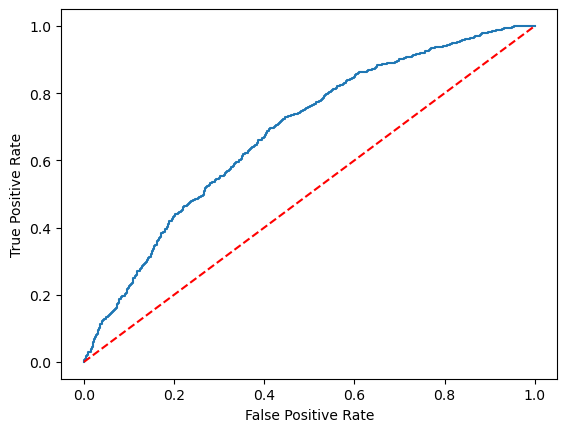

In [12]:
y_pred = model.predict(x_test, verbose=0)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # test dataset
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print(f'M&F model AUC score: {roc_auc_score(y_test, y_pred)}')

In [31]:
import time
explainer = shap.KernelExplainer(model.predict, x_train[::240])  # take ~100 priors (24,000/240), not recommended to have large amount here
shap_values = explainer.shap_values(x_test, nsamples=500)  # takes ~53 minutes w/ nsamples=500

3/3 [==============================] - 0s 1ms/step


  0%|          | 0/2427 [00:00<?, ?it/s]

1266/1266 [==============================] - 1s 631us/step


1266/1266 [==============================] - 1s 667us/step


1266/1266 [==============================] - 1s 567us/step


1266/1266 [==============================] - 1s 568us/step


1266/1266 [==============================] - 1s 569us/step


1266/1266 [==============================] - 1s 568us/step


1266/1266 [==============================] - 1s 604us/step


1266/1266 [==============================] - 1s 597us/step


1266/1266 [==============================] - 1s 573us/step


1266/1266 [==============================] - 1s 573us/step


1266/1266 [==============================] - 1s 587us/step


1266/1266 [==============================] - 1s 575us/step


1266/1266 [==============================] - 1s 563us/step


1266/1266 [==============================] - 1s 566us/step


1266/1266 [==============================] - 1s 842us/step


1266/1266 [==============================] - 1s 580us/step


1266/1266 [==============================] - 1s 584us/step
3149.3137769699097


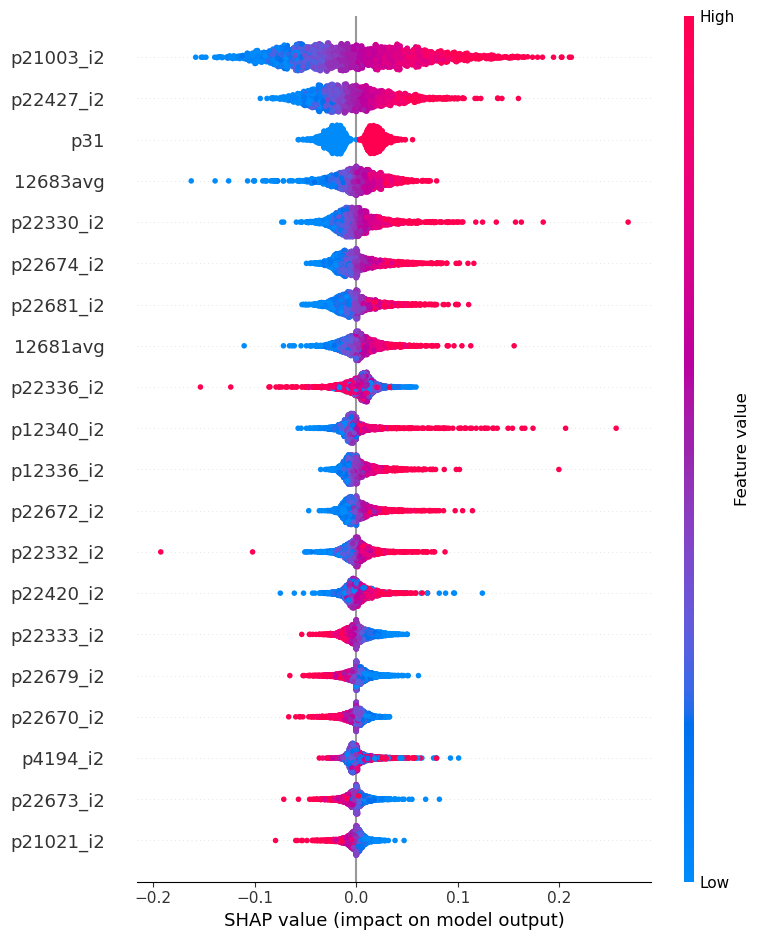

In [48]:
shap.summary_plot(shap_values[0], x_test)

In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_test)

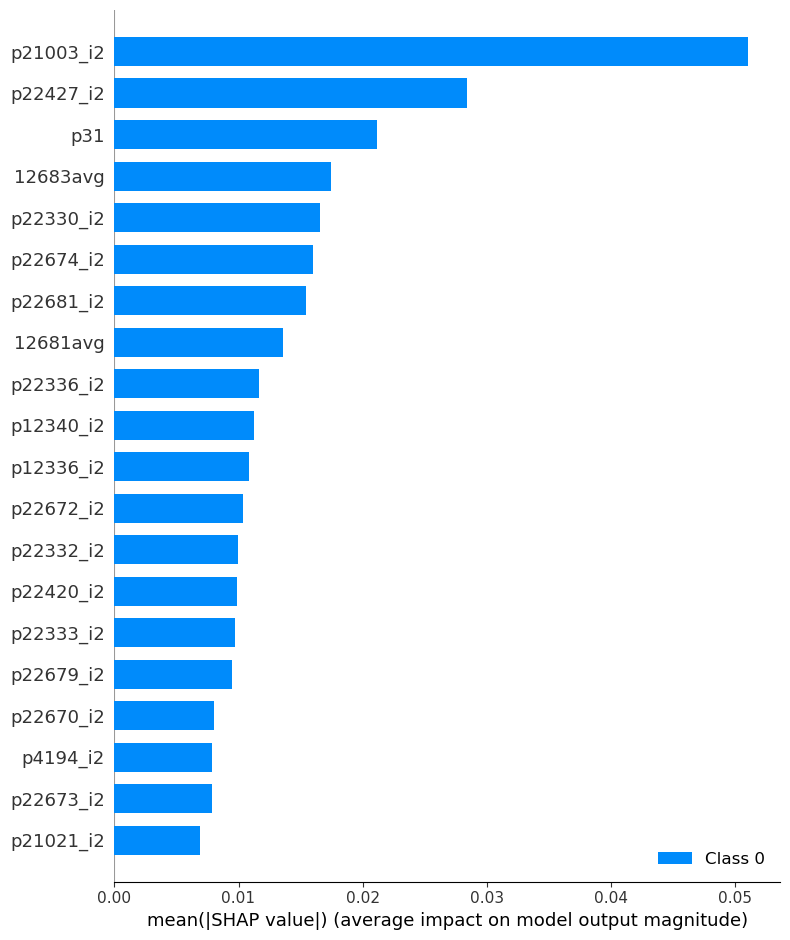

In [57]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [ ]:
# Top 5 predictors: Age, body surface area, sex, end systolic pressure (blood pressure), PQ interval (ECG)